In [1]:
import matplotlib.pyplot as plt  # plotting library
import numpy as np
import pandas as pd
import random

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import einops
from einops.layers.torch import Rearrange


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Selected device: {device}")

data_dir = "dataset"

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = test_transform = transforms.ToTensor()
train_dataset.transform = train_transform
test_dataset.transform = test_transform

m = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m - m * 0.2), int(m * 0.2)])
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

Selected device: cuda


In [45]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.main_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            Rearrange("b c h w -> b (c h w)"),
        )
        self.mu = nn.LazyLinear(latent_dims)  # mean
        self.log_var = nn.LazyLinear(latent_dims)  # covar

    def sample(self, mu, log_var):
        std = log_var.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z

    def forward(self, x):
        x = x.to(device)
        x = self.main_block(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.sample(mu, log_var)
        return z, mu, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.main_block = nn.Sequential(
            nn.Linear(latent_dims, 32 * 3 * 3),
            Rearrange("b (c h w) -> b c h w", c=32, h=3, w=3),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.to(device)
        return self.main_block(x)


class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z, mu, log_var = self.encoder(x)
        return self.decoder(z), z, mu, log_var


In [46]:
### Set the random seed for reproducible results
torch.manual_seed(0)

latent_dims = 30
vae = VariationalAutoencoder(latent_dims=latent_dims)

lr = 1e-3
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

vae.to(device)


/home/advait/miniconda3/envs/rohan/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


VariationalAutoencoder(
  (encoder): Encoder(
    (main_block): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Dropout2d(p=0.5, inplace=False)
      (9): Rearrange('b c h w -> b (c h w)')
    )
    (mu): LazyLinear(in_features=0, out_features=30, bias=True)
    (log_var): LazyLinear(in_features=0, out_features=30, bias=True)
  )
  (decoder): Decoder(
    (main_block): Sequential(
      (0): Linear(in_features=30, out_features=288, bias=True)
      (1): Rearrange('b (c h w) -> b c h w', c=32, h=3, w=3)
      (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, 

In [47]:
def loss_function(x_hat, x, mu, log_var):
    bce = F.binary_cross_entropy(x_hat, x, reduction="sum")
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce + kl


def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader:
        # Move tensor to the proper device
        x = x.to(device)
        x_hat, _, mu, log_var = vae(x)
        loss = loss_function(x_hat, x, mu, log_var)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    return train_loss / len(dataloader.dataset)


def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad():  # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            x_hat, _, mu, log_var = vae(x)
            loss = loss_function(x_hat, x, mu, log_var)
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)


def plot_ae_outputs(vae, n=10):
    plt.figure(figsize=(16, 4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i: np.where(targets == i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        vae.eval()
        with torch.no_grad():
            x_hat, _, _, _ = vae(img)
        plt.imshow(img.cpu().squeeze().numpy(), cmap="gist_gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Original images")
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_hat.cpu().squeeze().numpy(), cmap="gist_gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Reconstructed images")
    plt.show()


Beginning training


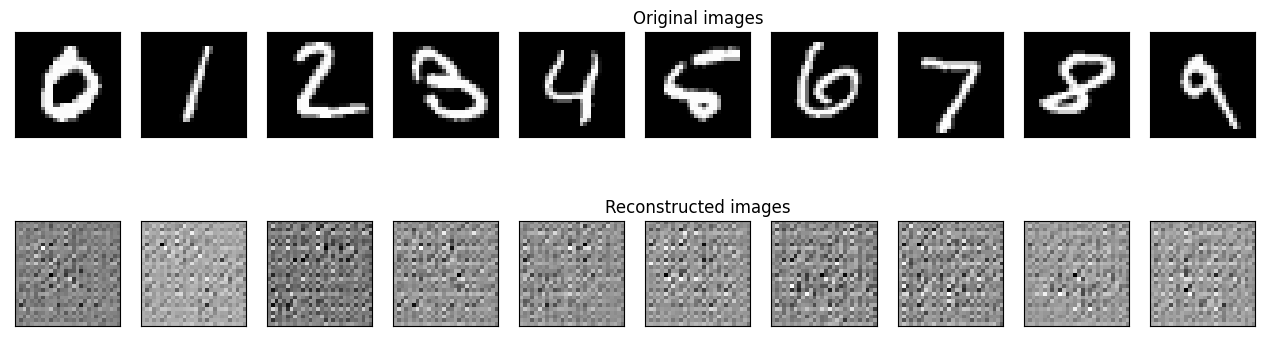


 EPOCH 1/500 	 train loss 324.911 	 val loss 241.884


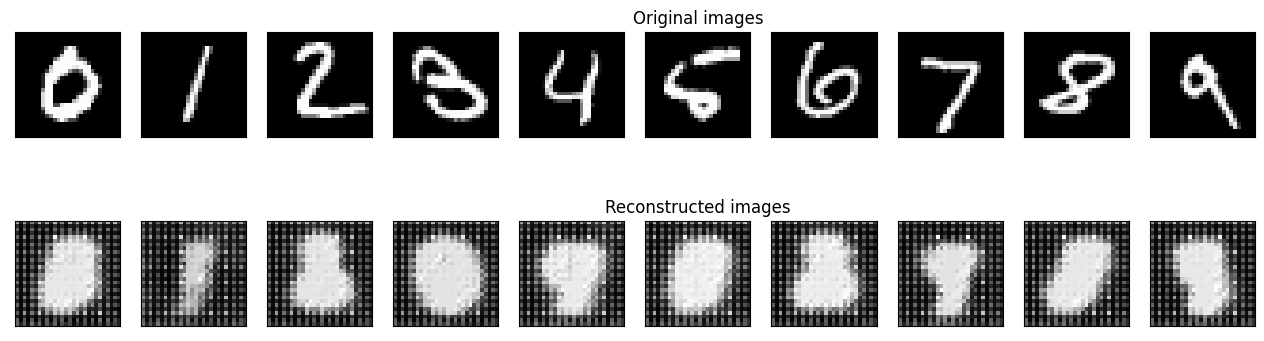


 EPOCH 2/500 	 train loss 214.357 	 val loss 193.506


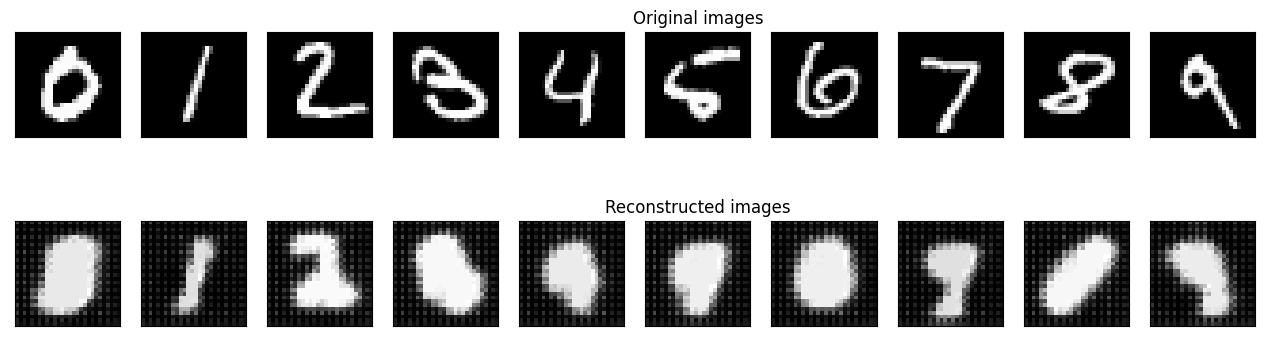


 EPOCH 3/500 	 train loss 187.863 	 val loss 178.935


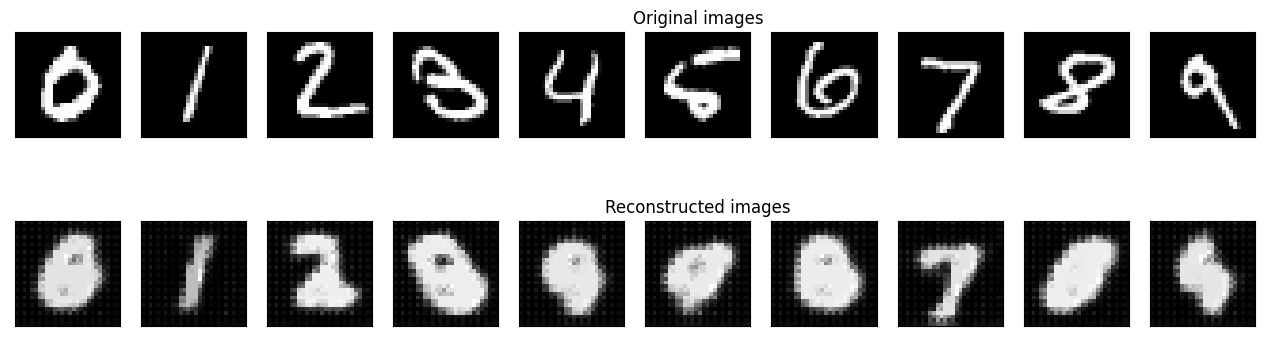


 EPOCH 4/500 	 train loss 177.957 	 val loss 170.167


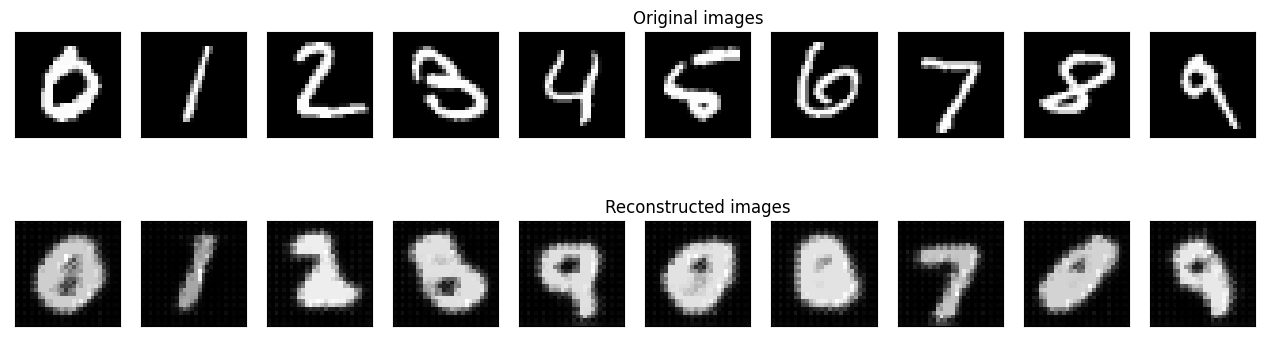


 EPOCH 5/500 	 train loss 171.385 	 val loss 163.823


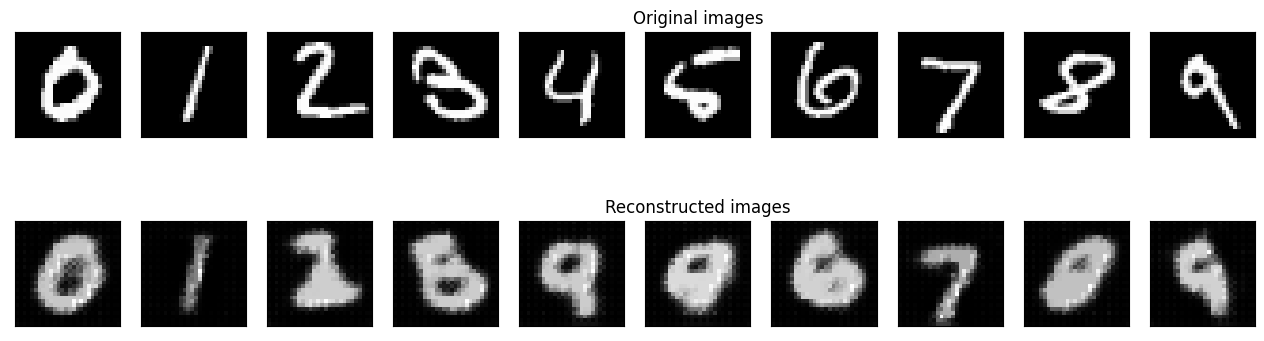


 EPOCH 6/500 	 train loss 166.498 	 val loss 158.852


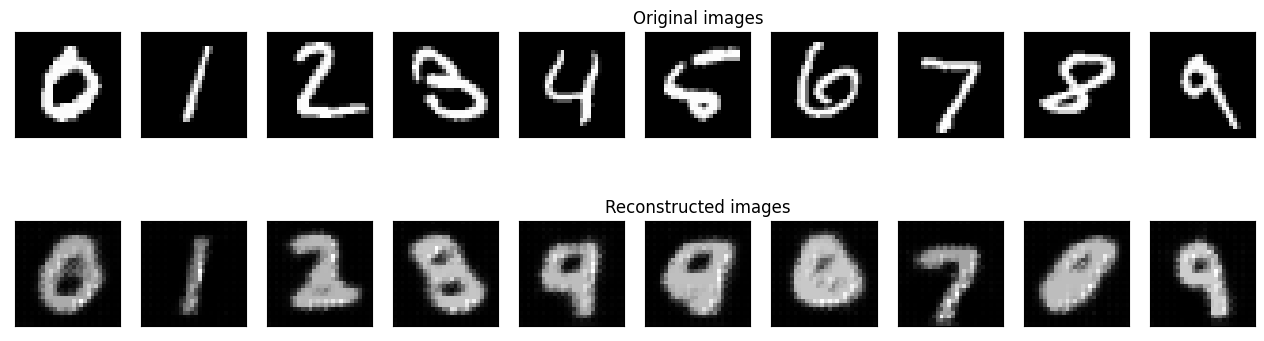


 EPOCH 7/500 	 train loss 162.429 	 val loss 154.982


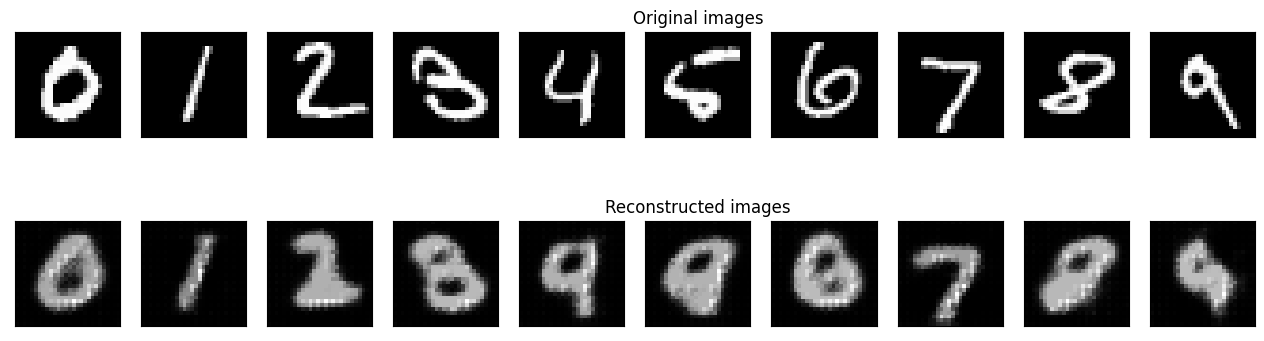


 EPOCH 8/500 	 train loss 158.803 	 val loss 150.765


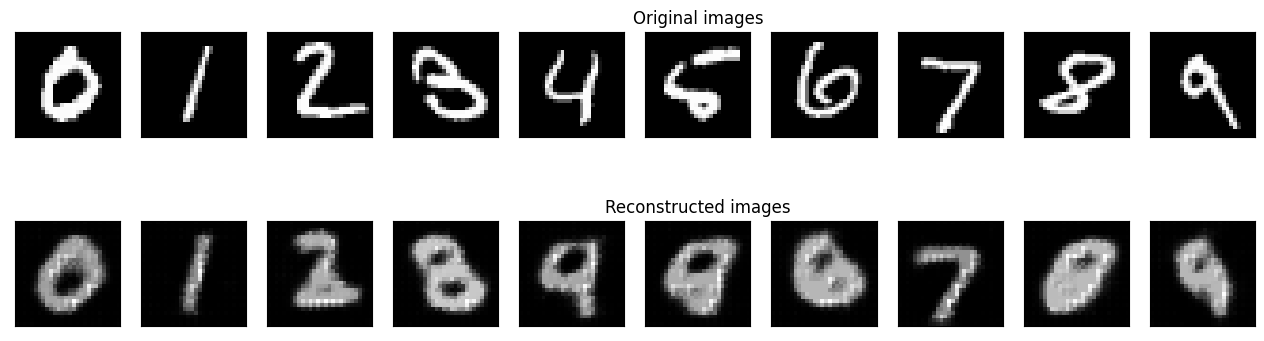


 EPOCH 9/500 	 train loss 155.593 	 val loss 147.063


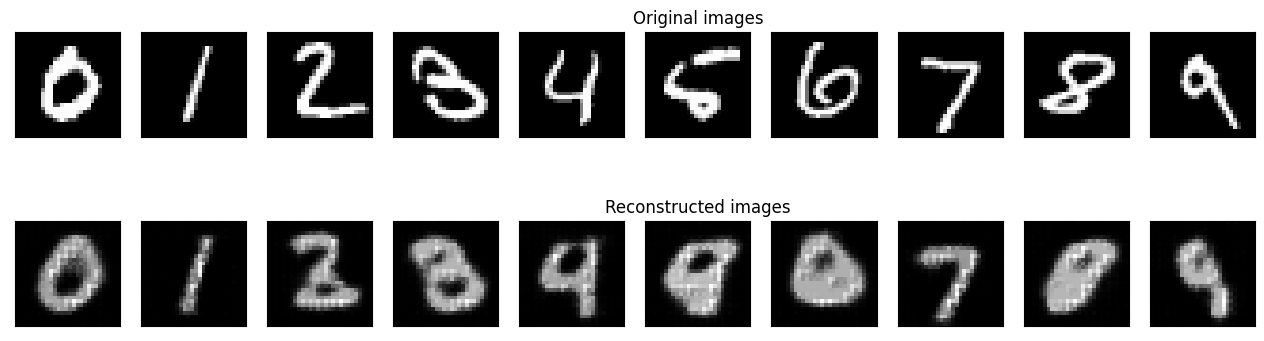


 EPOCH 10/500 	 train loss 152.777 	 val loss 143.882


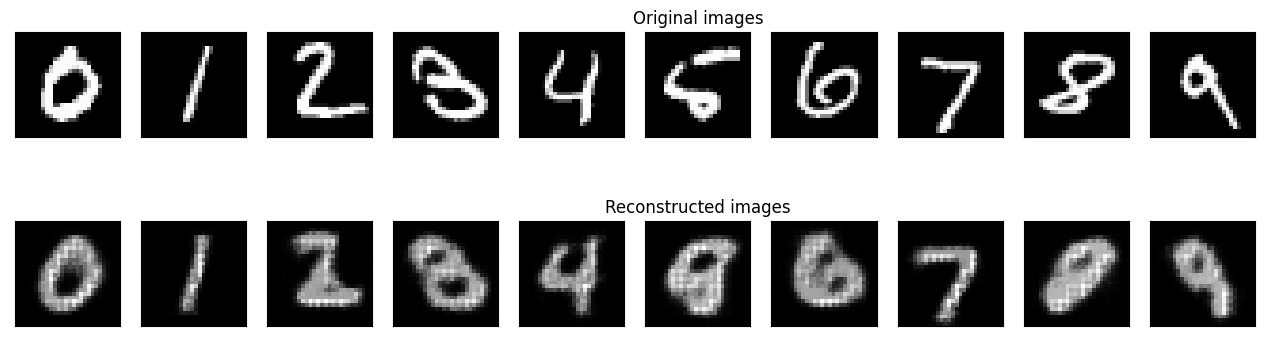


 EPOCH 11/500 	 train loss 149.626 	 val loss 139.516


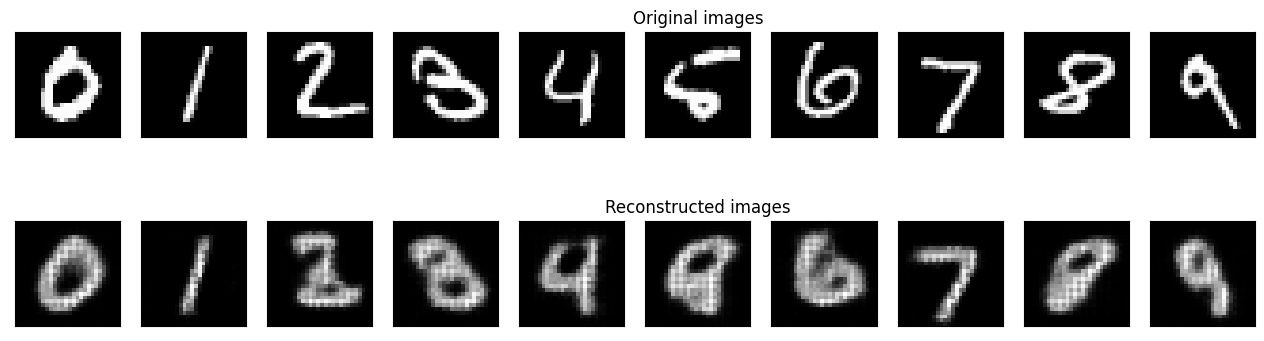


 EPOCH 12/500 	 train loss 146.978 	 val loss 137.812


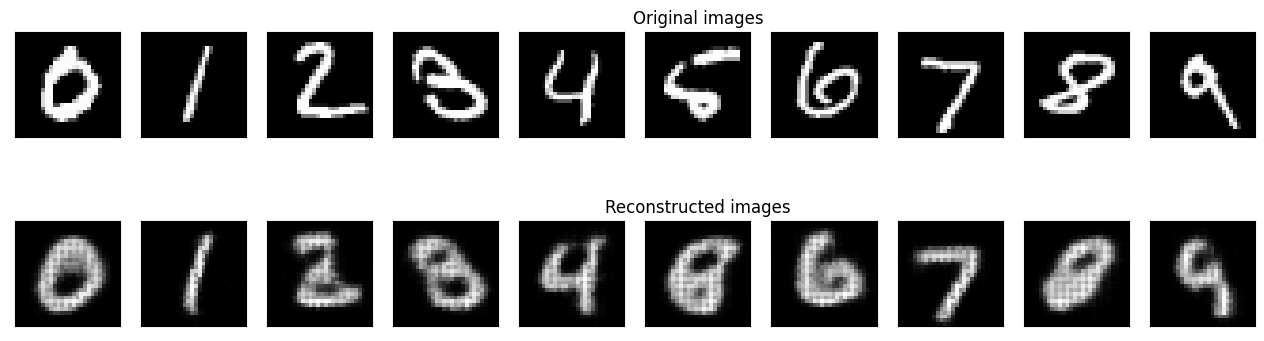


 EPOCH 13/500 	 train loss 144.523 	 val loss 135.130


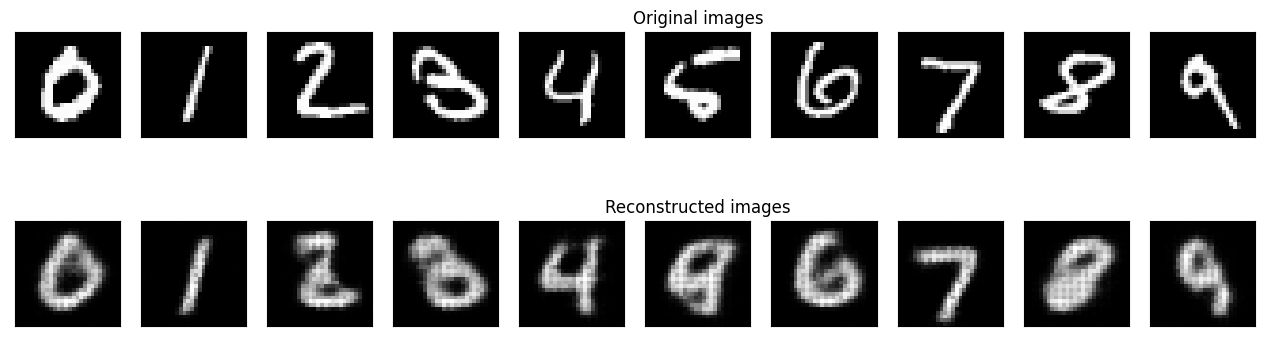


 EPOCH 14/500 	 train loss 142.706 	 val loss 132.646


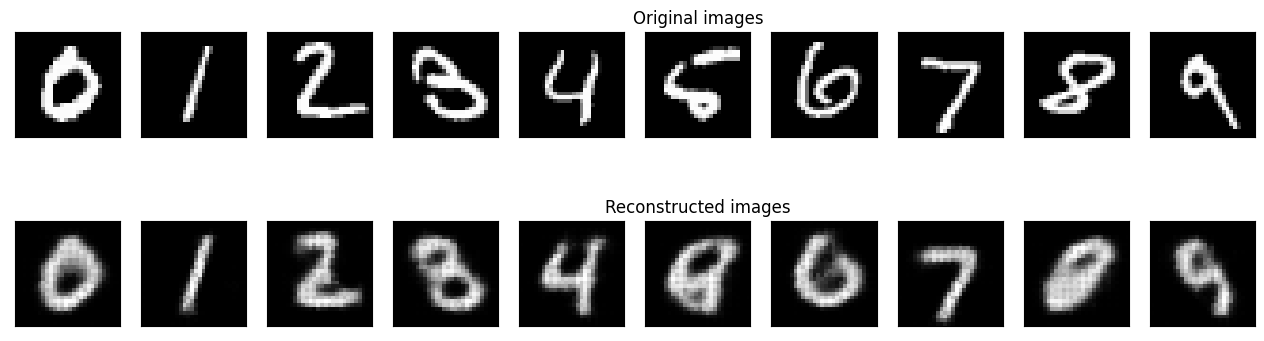


 EPOCH 15/500 	 train loss 141.523 	 val loss 131.148


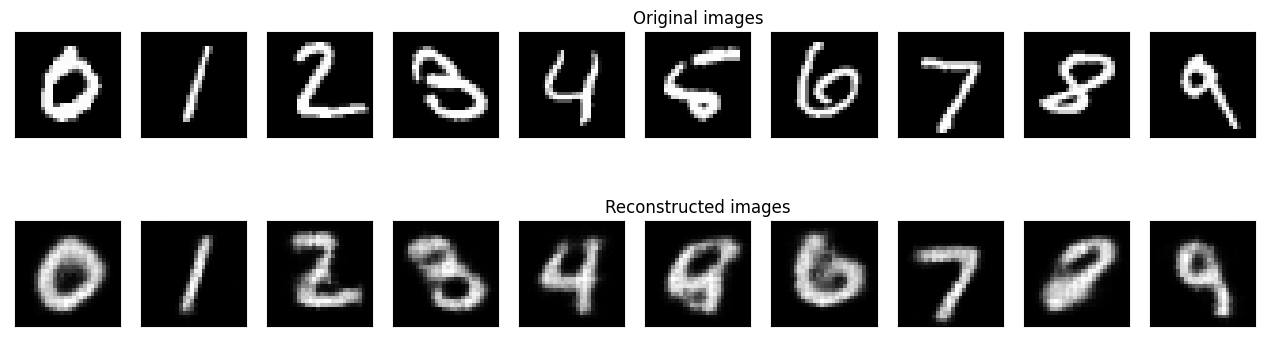


 EPOCH 16/500 	 train loss 140.631 	 val loss 130.102


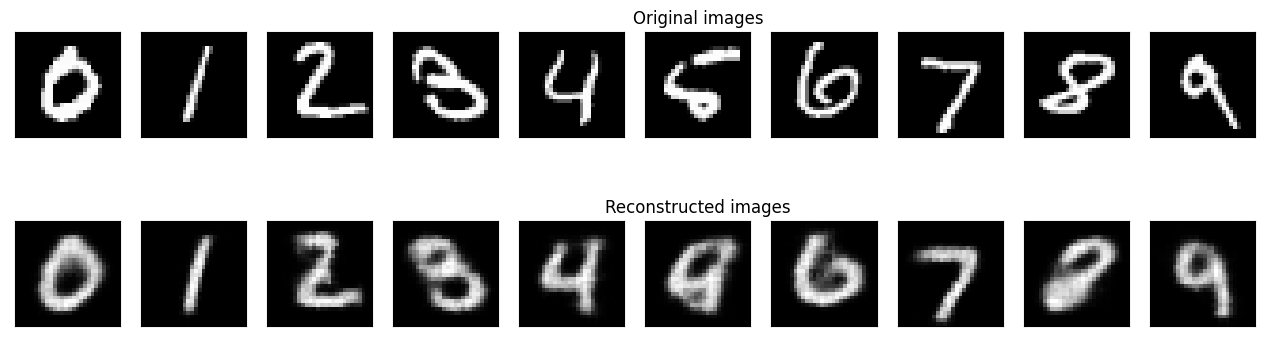


 EPOCH 17/500 	 train loss 139.625 	 val loss 130.115


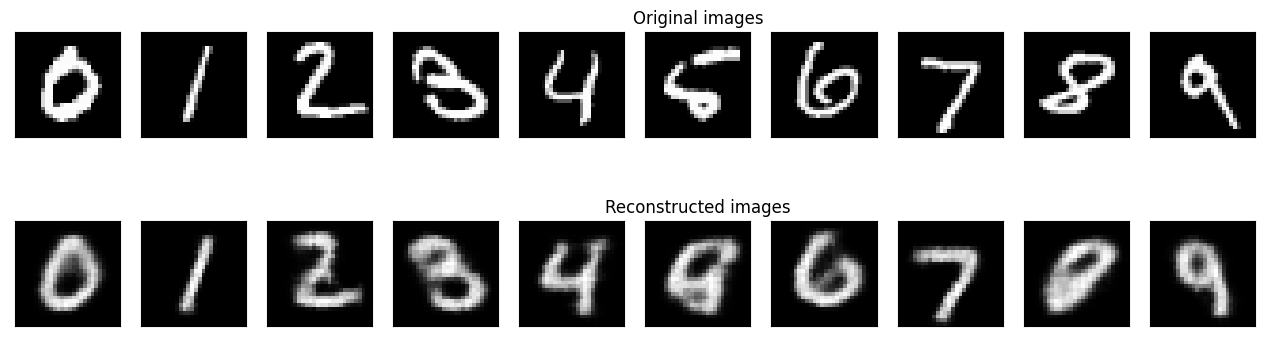


 EPOCH 18/500 	 train loss 139.079 	 val loss 128.657


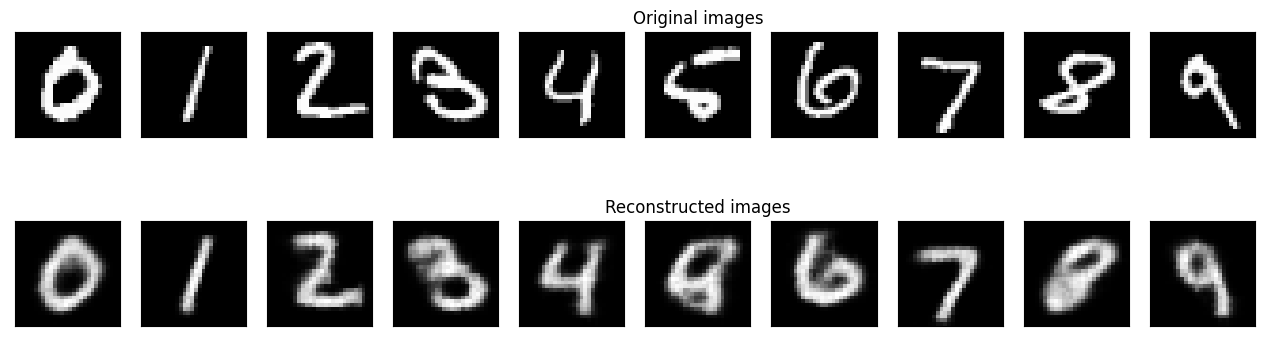


 EPOCH 19/500 	 train loss 138.389 	 val loss 128.238


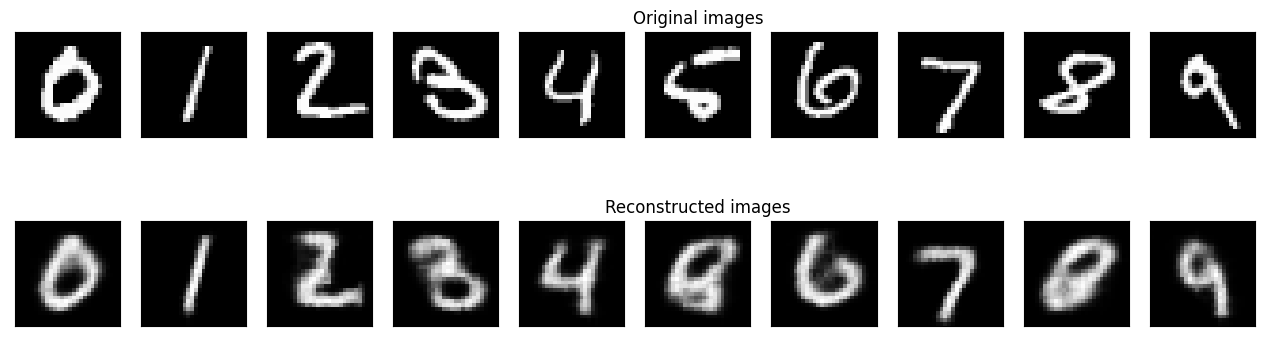


 EPOCH 20/500 	 train loss 137.993 	 val loss 127.870


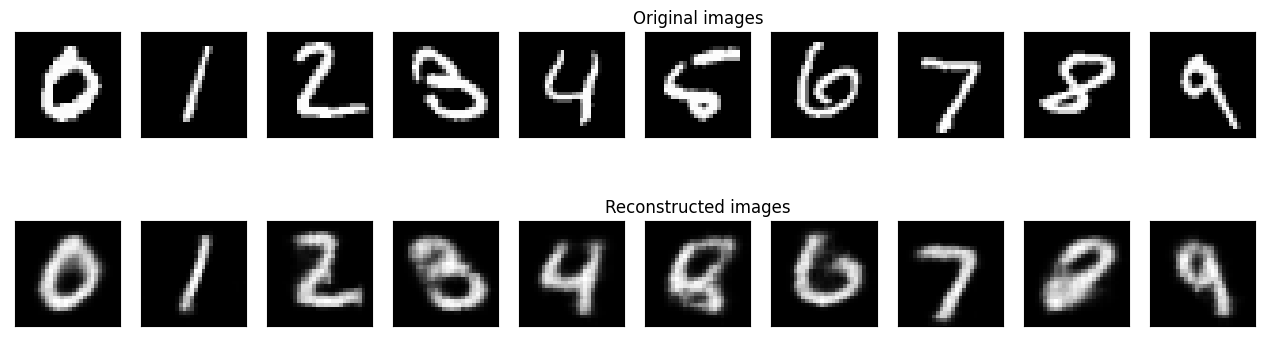


 EPOCH 21/500 	 train loss 137.532 	 val loss 127.751


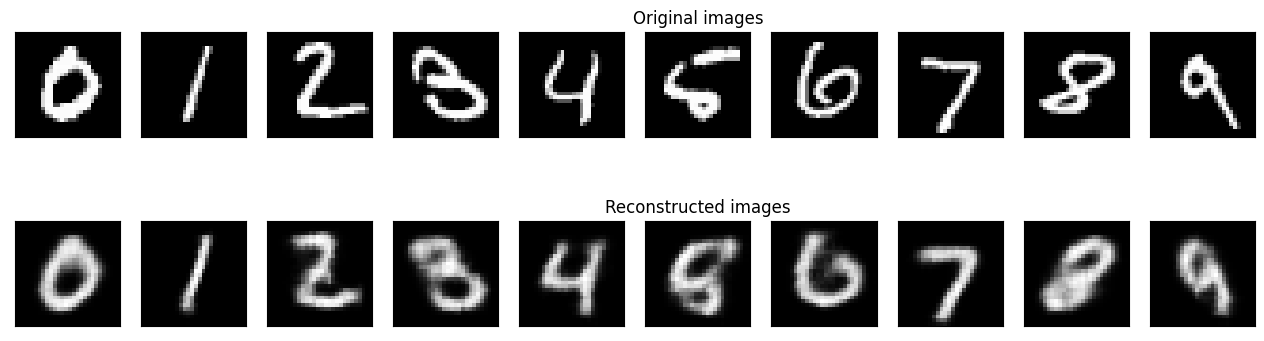


 EPOCH 22/500 	 train loss 137.245 	 val loss 127.683


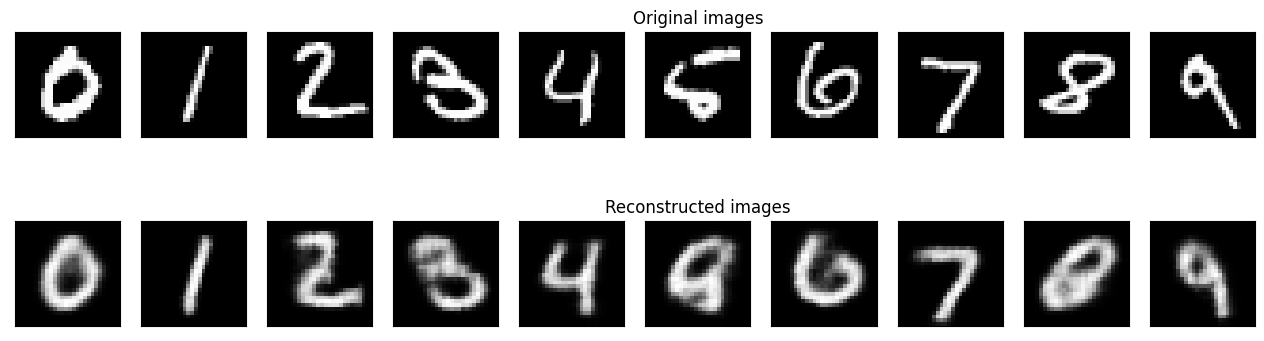


 EPOCH 23/500 	 train loss 136.670 	 val loss 126.916


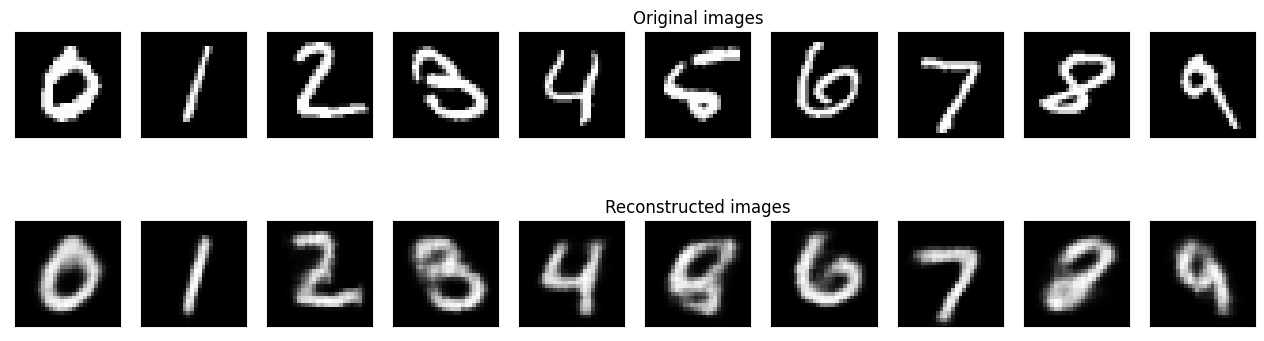


 EPOCH 24/500 	 train loss 136.623 	 val loss 126.227


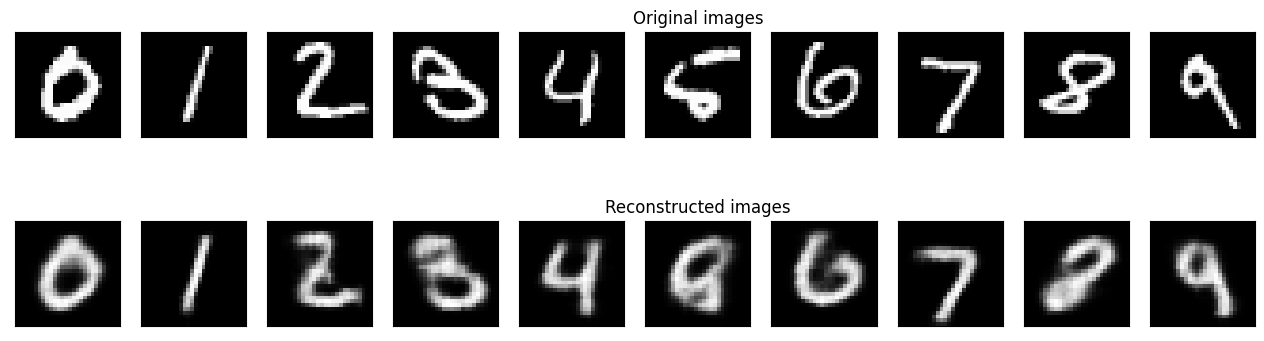


 EPOCH 25/500 	 train loss 136.135 	 val loss 125.863


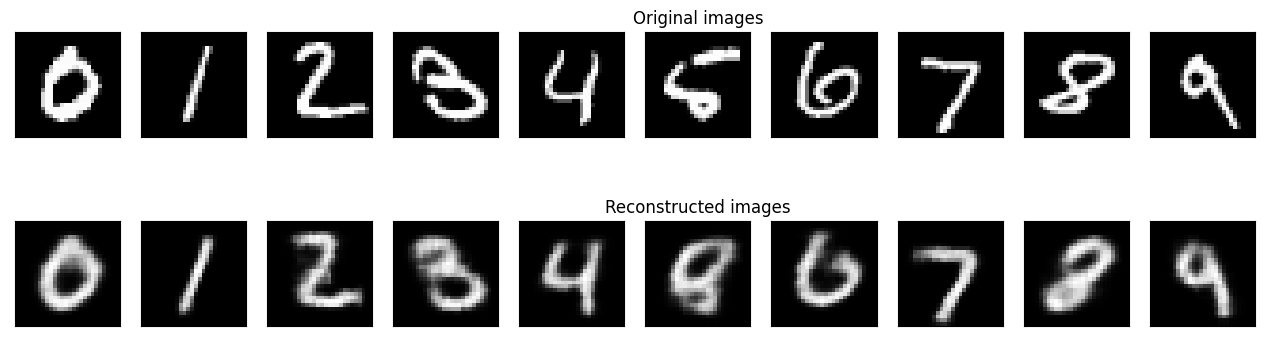


 EPOCH 26/500 	 train loss 135.874 	 val loss 125.874


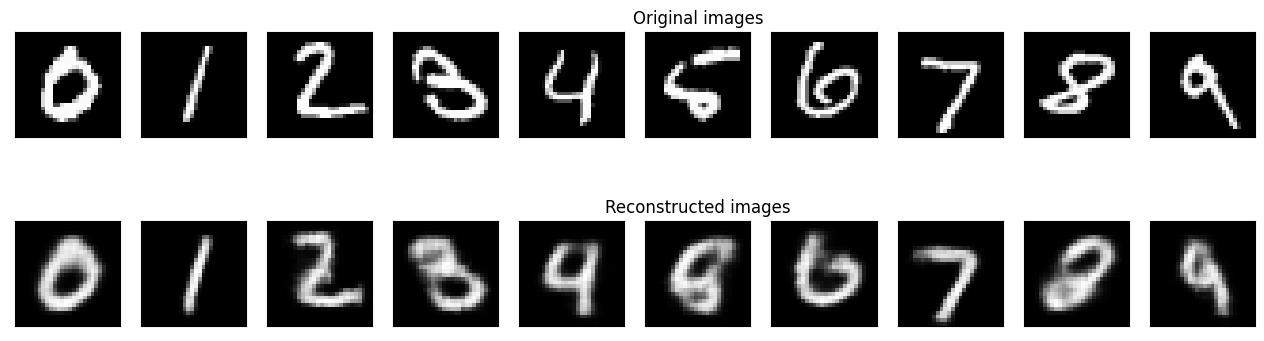


 EPOCH 27/500 	 train loss 135.361 	 val loss 124.641


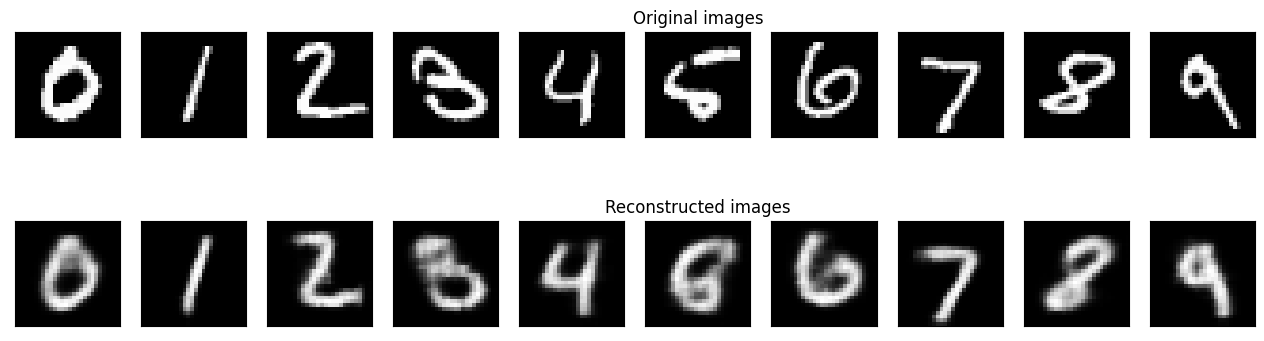


 EPOCH 28/500 	 train loss 134.822 	 val loss 123.973


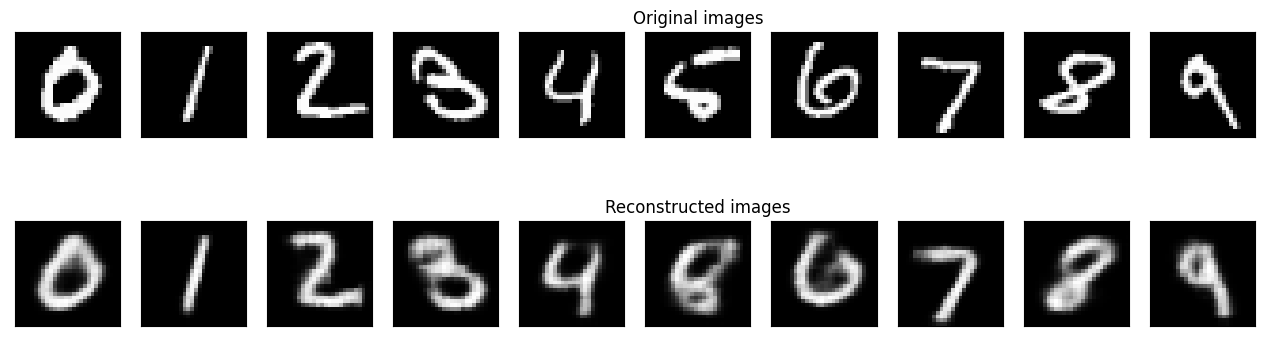


 EPOCH 29/500 	 train loss 134.107 	 val loss 123.647


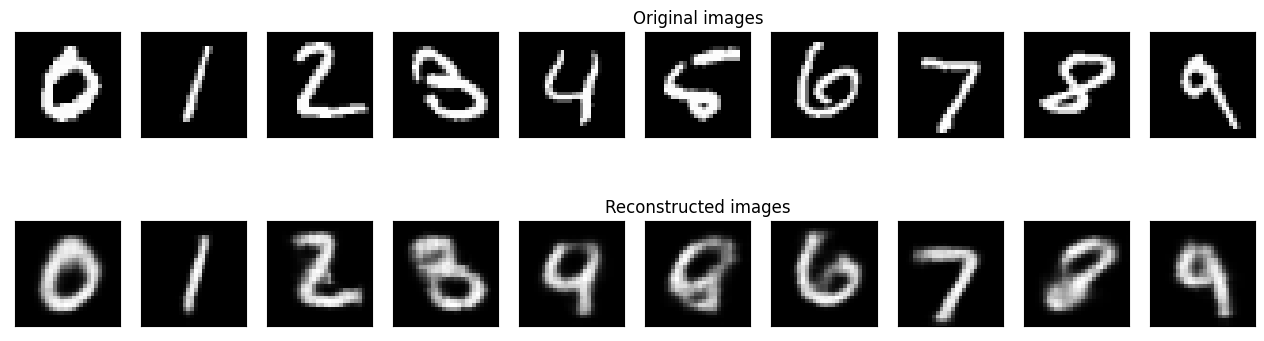


 EPOCH 30/500 	 train loss 133.728 	 val loss 123.098


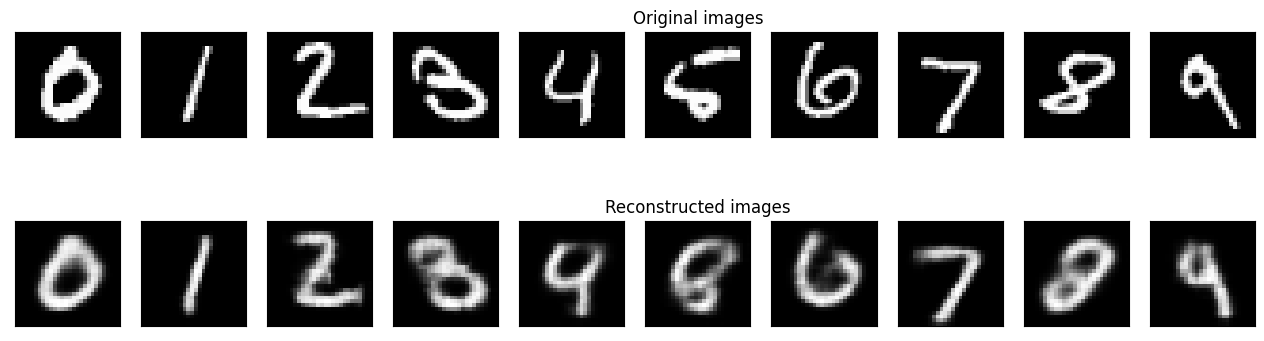


 EPOCH 31/500 	 train loss 133.492 	 val loss 123.059


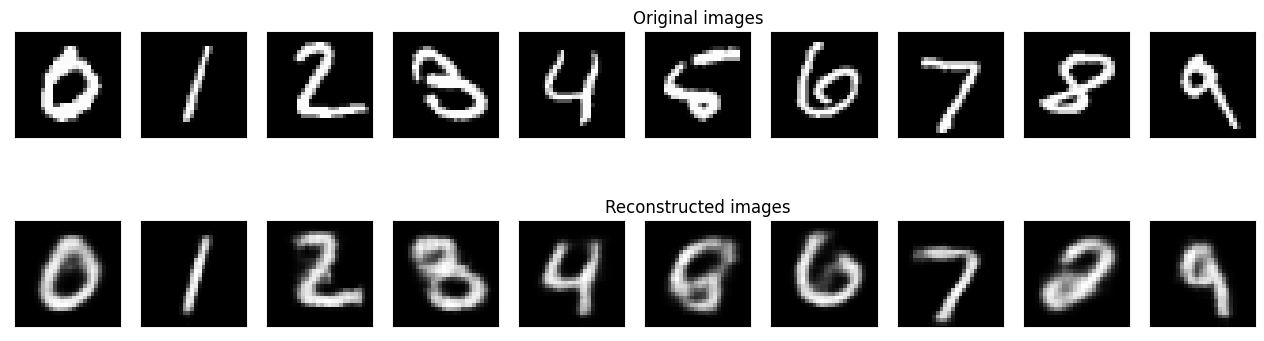


 EPOCH 32/500 	 train loss 133.270 	 val loss 122.778


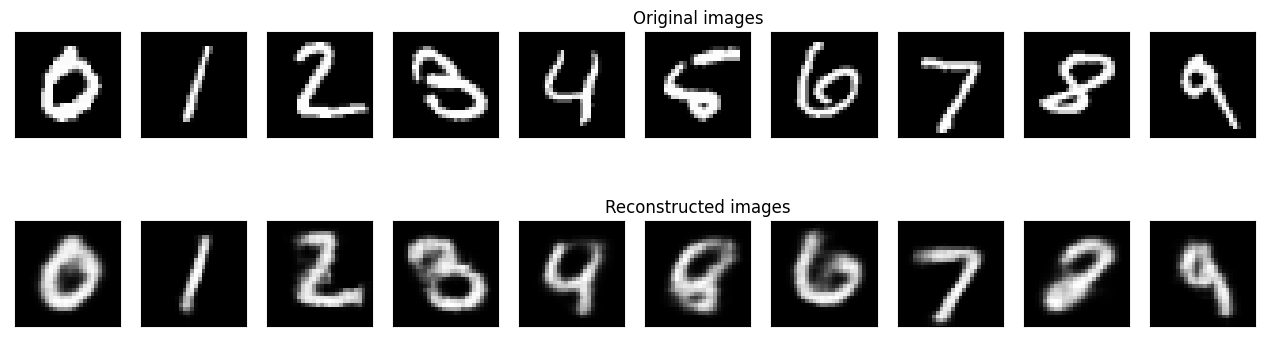


 EPOCH 33/500 	 train loss 133.007 	 val loss 122.305


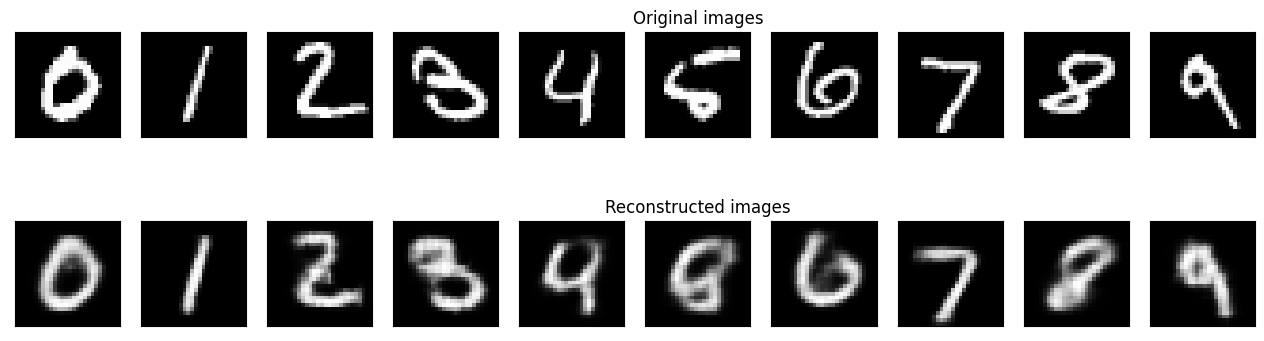


 EPOCH 34/500 	 train loss 132.808 	 val loss 122.340


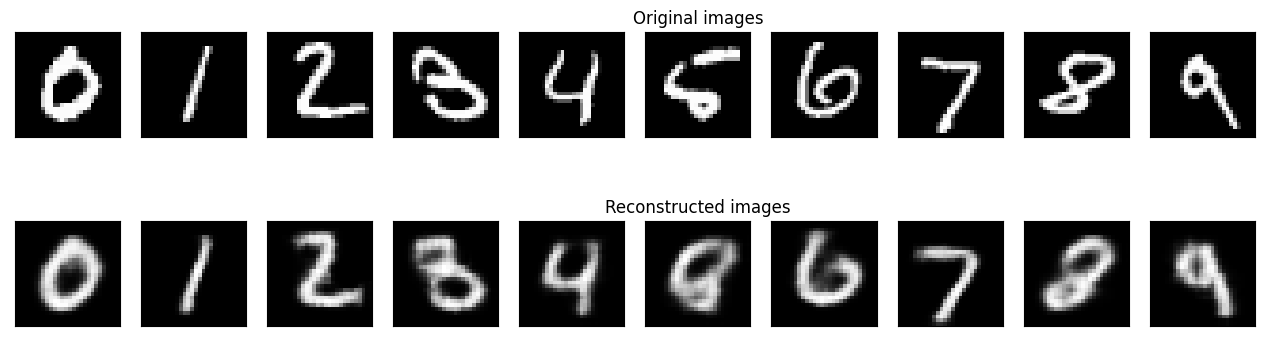


 EPOCH 35/500 	 train loss 132.560 	 val loss 122.664


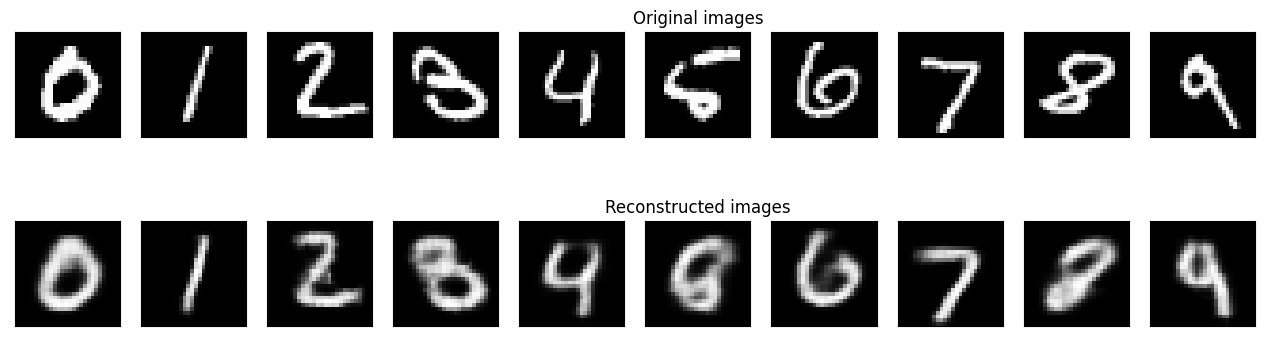


 EPOCH 36/500 	 train loss 132.459 	 val loss 122.188


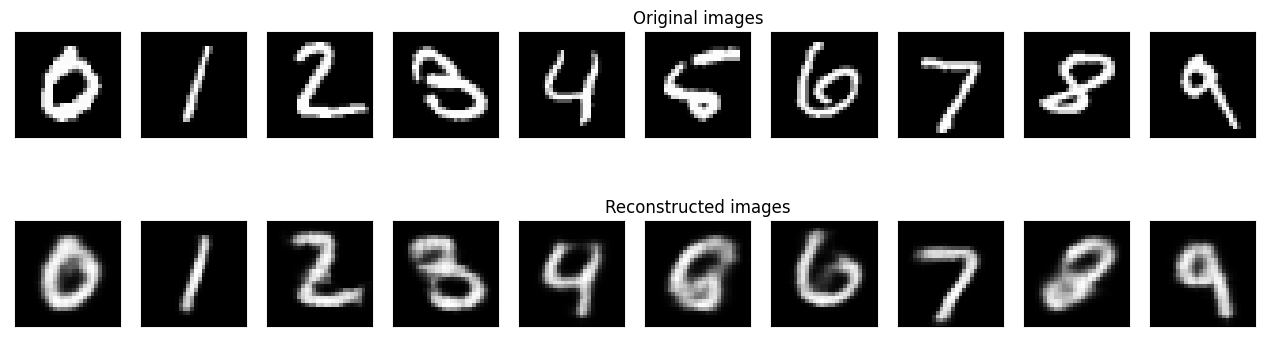


 EPOCH 37/500 	 train loss 132.223 	 val loss 121.982


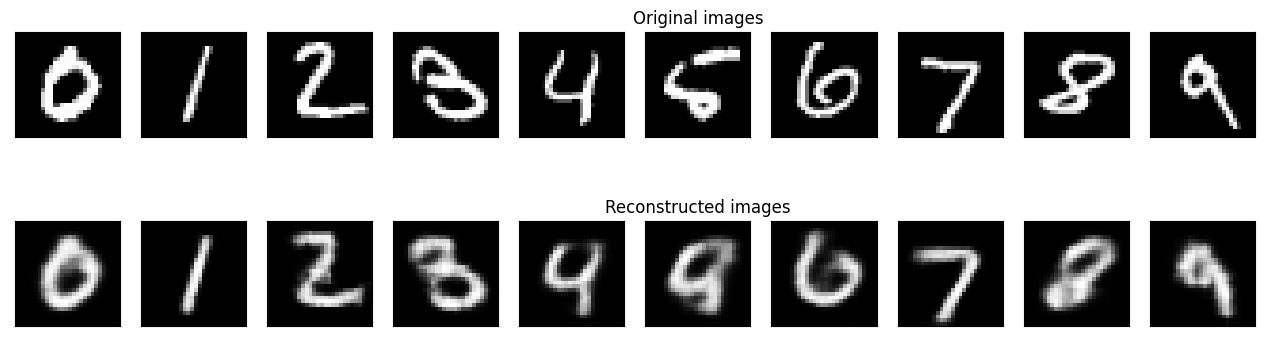


 EPOCH 38/500 	 train loss 131.989 	 val loss 121.870


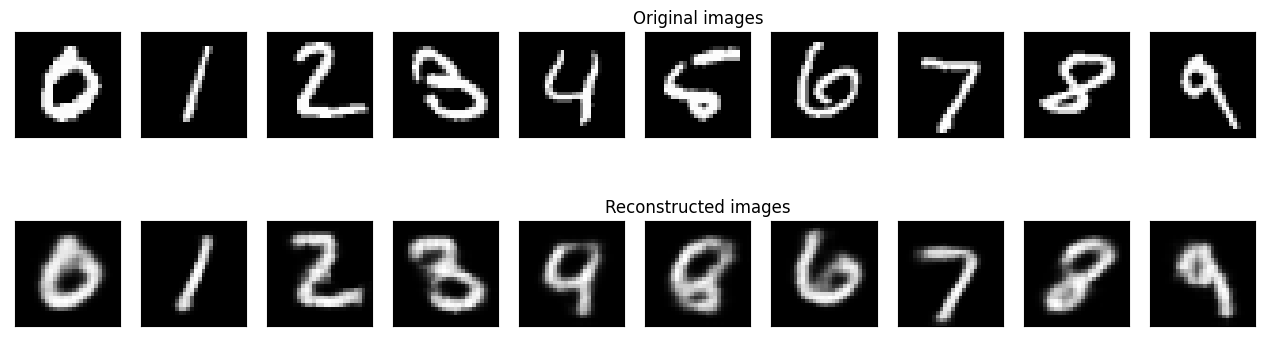


 EPOCH 39/500 	 train loss 131.693 	 val loss 121.626


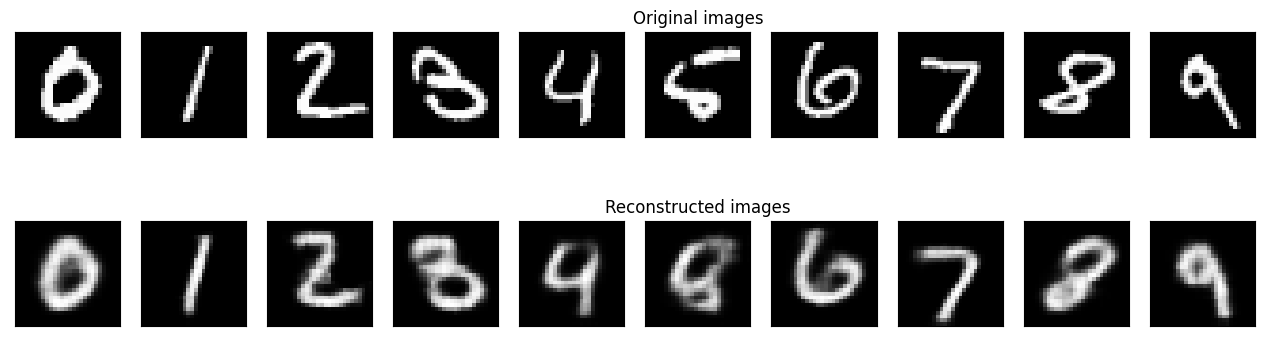


 EPOCH 40/500 	 train loss 131.819 	 val loss 121.464


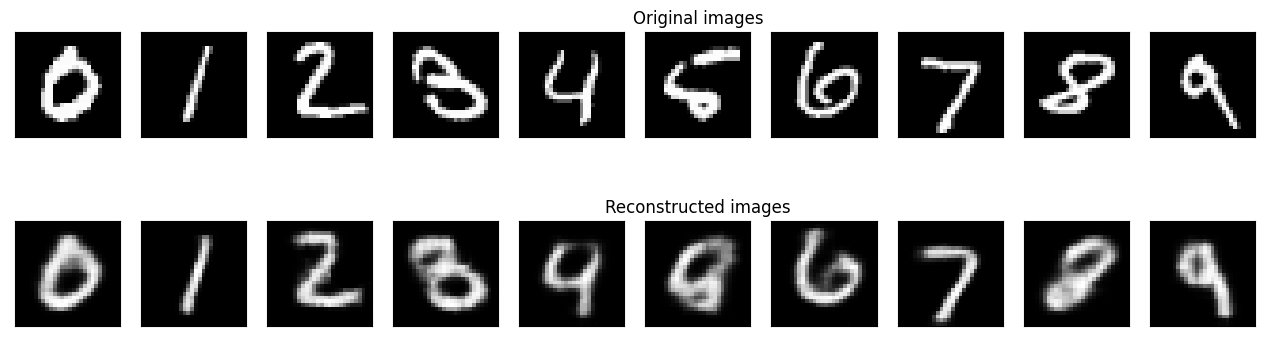


 EPOCH 41/500 	 train loss 131.624 	 val loss 121.361


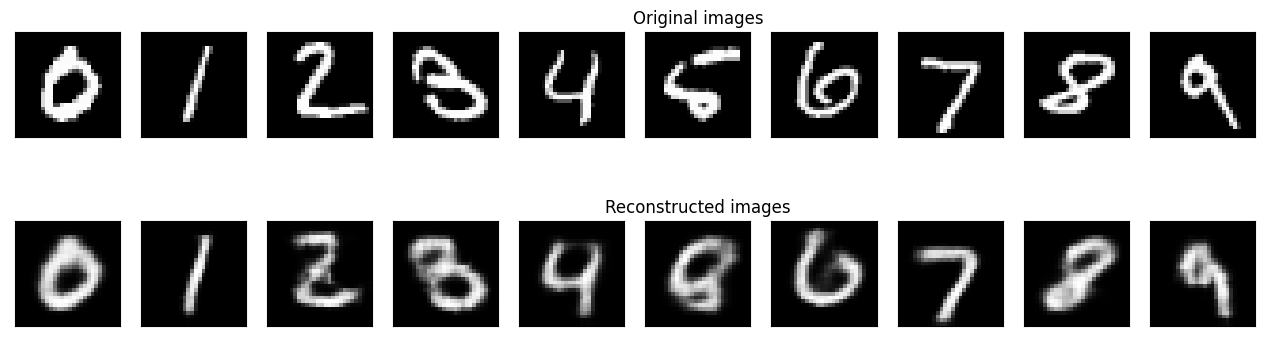


 EPOCH 42/500 	 train loss 131.505 	 val loss 121.482


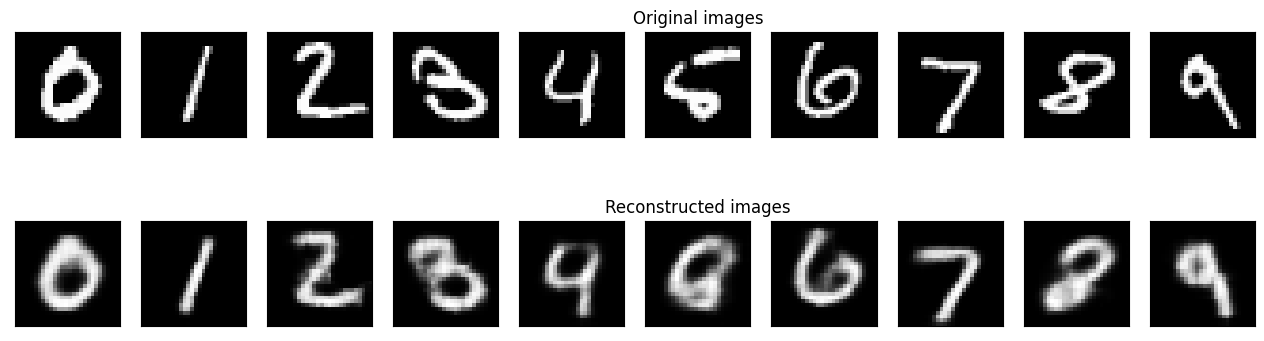


 EPOCH 43/500 	 train loss 131.305 	 val loss 121.109


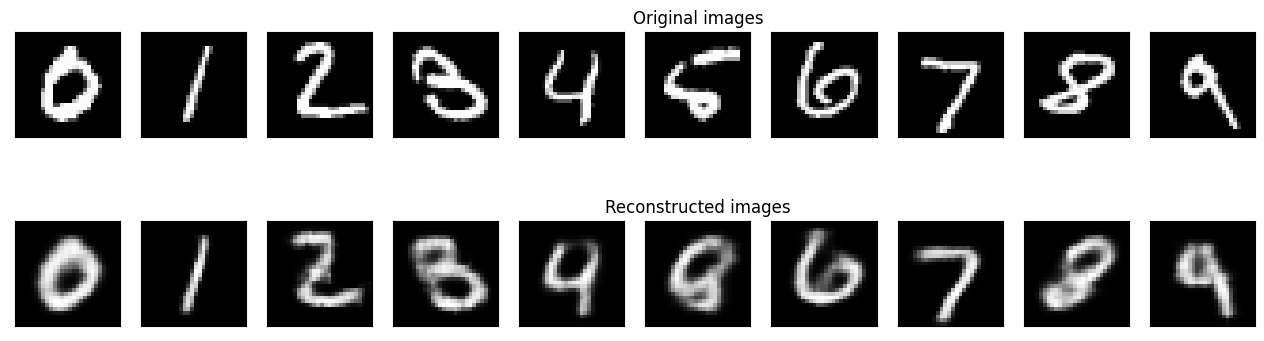


 EPOCH 44/500 	 train loss 131.209 	 val loss 121.439


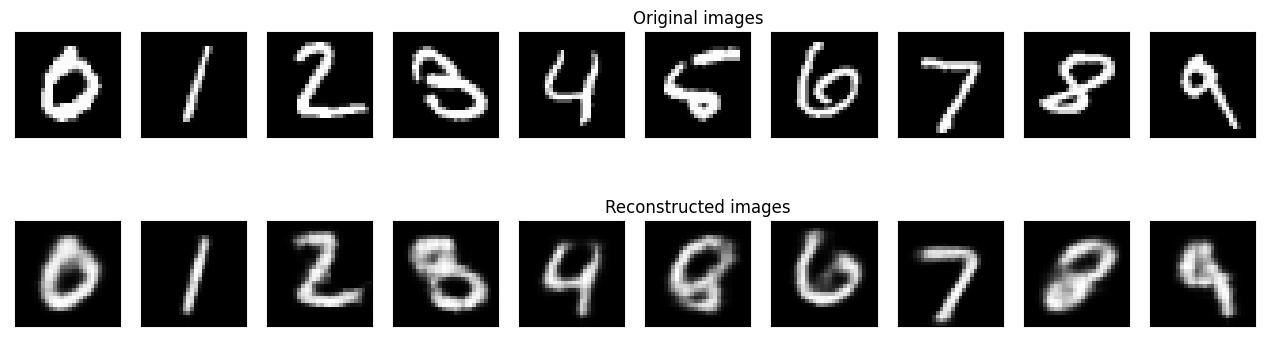


 EPOCH 45/500 	 train loss 130.989 	 val loss 120.946


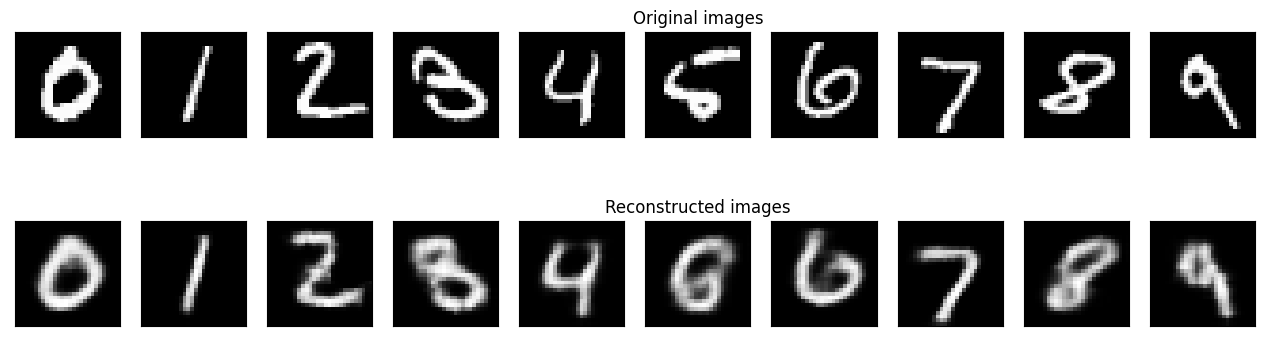


 EPOCH 46/500 	 train loss 130.855 	 val loss 120.712


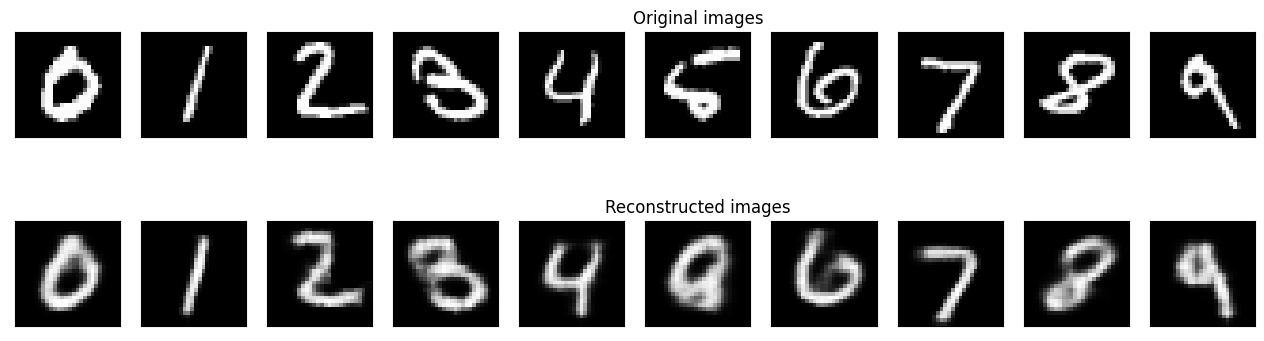


 EPOCH 47/500 	 train loss 130.794 	 val loss 120.807


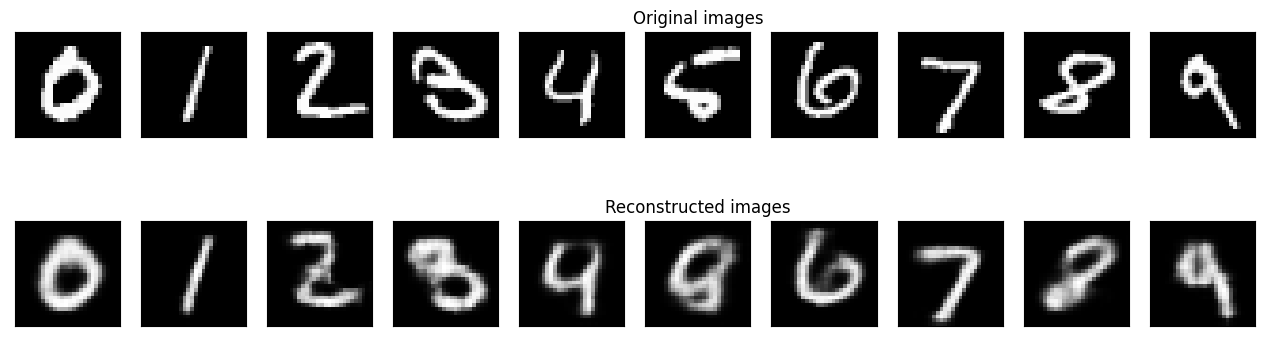


 EPOCH 48/500 	 train loss 130.713 	 val loss 120.728


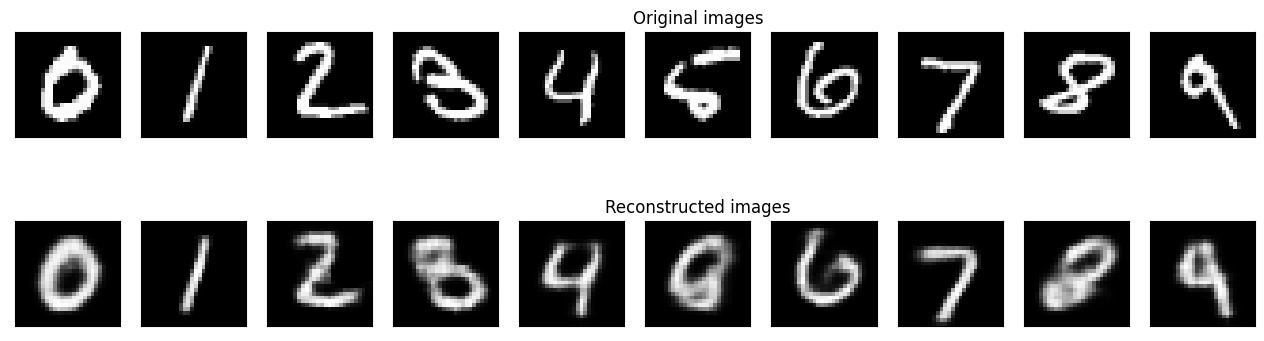


 EPOCH 49/500 	 train loss 130.555 	 val loss 120.995


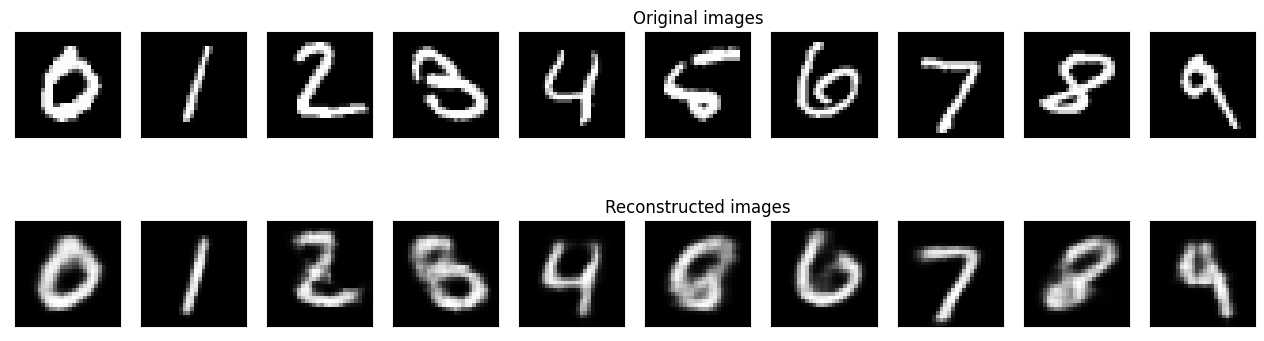

Validation loss is no longer shrinking. Quitting early.


In [48]:
num_epochs = 500
val_losses = []

print("Beginning training")
plot_ae_outputs(vae, n=10)

for epoch in range(num_epochs):
    train_loss = train_epoch(vae, device, train_loader, optim)
    val_loss = test_epoch(vae, device, valid_loader)
    val_losses.append(val_loss)
    print(
        "\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}".format(
            epoch + 1, num_epochs, train_loss, val_loss
        )
    )
    plot_ae_outputs(vae, n=10)
    if len(val_losses) >= 5 and val_losses[-5] < val_loss:
        print("Validation loss is no longer shrinking. Quitting early.")
        break


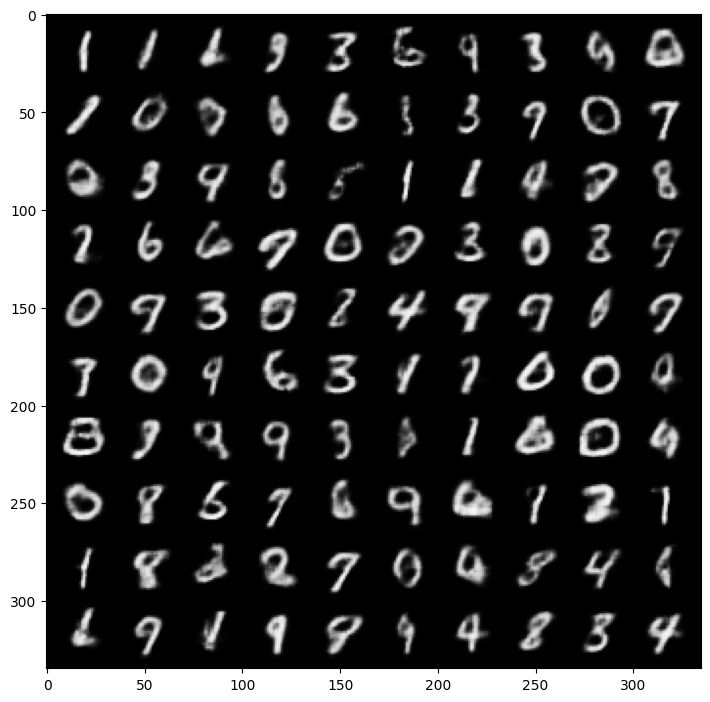

In [49]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():
    # sample latent vectors from the normal distribution
    latent = torch.randn(100, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data, 10, 5))
    plt.show()


tensor([[-2.6089e-01, -5.2491e-01,  1.7817e-03,  ...,  6.0534e-03,
         -3.8949e-02,  3.4981e-02],
        [ 5.6228e-02,  2.0399e+00,  9.3498e-03,  ..., -2.5143e-04,
         -5.9406e-03,  6.2029e-03],
        [ 2.2964e-01,  7.0239e+01,  5.7289e-03,  ...,  2.5430e-03,
         -5.7471e-02, -1.6202e-03],
        ...,
        [-1.3823e-01, -2.8664e+01, -1.5510e-03,  ...,  1.1546e-03,
         -4.0158e-01,  1.2205e-02],
        [ 1.0670e+00, -2.6872e-01, -3.9159e-03,  ...,  3.3327e-03,
         -9.3218e-03,  6.1369e-03],
        [-9.5604e-04, -5.1803e+00, -2.4602e-03,  ...,  9.8296e-04,
          1.7320e-01, -1.2871e-01]], device='cuda:0')


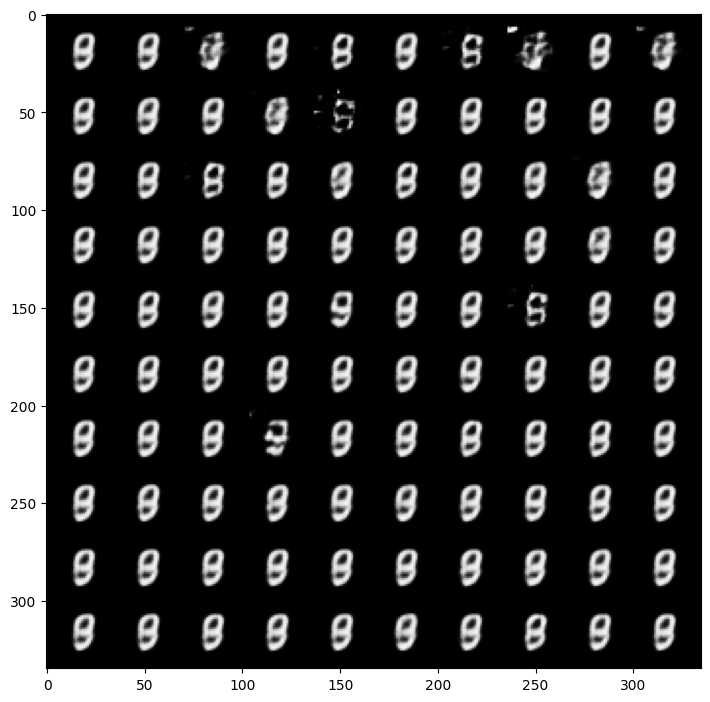

In [40]:
zeroes = [
    train_dataset.data[i]
    for i, label in enumerate(train_dataset.targets)
    if label == 0
]
zeroes = zeroes[:100]
zeroes = einops.rearrange(torch.stack(zeroes).type(torch.float32), "b h w -> b 1 h w")
zeroes.to(device)
with torch.no_grad():
    vae.eval()
    _, mu, log_var = vae.encoder(zeroes)

    # Average mu and log_var for zeroes in our dataset
    mu_avg = einops.reduce(mu, "b mu -> mu", "mean").cpu()
    log_var_avg = einops.reduce(log_var, "b l -> l", "mean").cpu()
    std_avg = log_var.cpu().mul(0.5).exp_()

    # Generate a bunch of zeroes from latent sampling
    esp = torch.randn(100, latent_dims, dtype=torch.float32)
    z = (esp.mul(std_avg).add(esp / 200)).to(device)
    print(z)

    img_recon = vae.decoder(z)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data, 10, 5))
    plt.show()


# def display(images):
#     fig, axs = plt.subplots(10, 10, figsize=(10, 10))
#     for i, image in enumerate(images):
#         axs[i // 10, i % 10].imshow(image, cmap="gray")
#     plt.show()
